https://www.devitoproject.org/devito/index.html

In [ ]:
pip install torch

In [ ]:
pip install tensorflow

In [ ]:
pip install --user git+https://github.com/devitocodes/devito.git

In [92]:
# import libraries and tools
import torch
import numpy as np
from random_fields import GaussianRF

from time import perf_counter

import matplotlib
import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

from devito import Grid, TimeFunction, Operator, Constant, Eq, solve, first_derivative, left

from examples.seismic import Model, plot_velocity
from examples.seismic import TimeAxis
from examples.seismic import RickerSource
from examples.seismic import Receiver

In [168]:
extent_x = 1.e3 ### METRES ###
extent_z = 1.e3 ### METRES ### 

nx = 101 ### NODES ### # coarser grid
nz = 101 ### NODES ###

absorbingLayer = 20 ### NODES ###

dx = extent_x / (nx-1) ### METRES ###
dz = extent_z / (nz-1) ### METRES ###

shape = (nx, nz)
spacing = (dx, dz)
origin = (0., 0.)

# create velocity model from random gaussian fields
grf = GaussianRF(2, shape[0]+1, alpha=2, tau=3)
v = torch.exp(grf.sample(1))[0].cpu().numpy()
v = v*2

t0 = 0.  ### MILLISECONDS ###
dt = model.critical_dt
T = 1000 ### MILLISECONDS ###
nt = int(((T ) / dt))
time_range = TimeAxis(start=t0, stop=T, step =dt)

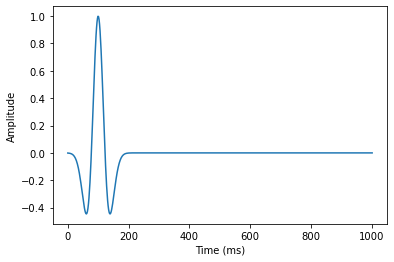

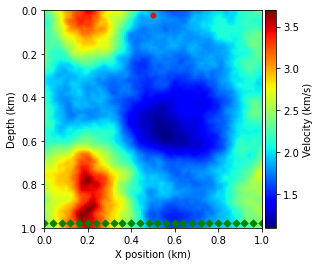

In [169]:
f0 = 0.01 ### kHZ ### # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, :] = extent_x*0.5 ### METRES ###
src.coordinates.data[0, -1] = 20 ### METRES ###

rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101) ### METRES ###
rec.coordinates.data[:, 1] = extent_z -20 ### METRES ###

# log all intermediate steps
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2, save=nt + 2)
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))

src_term = src.inject(field=u.forward, expr=src*dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

op = Operator([stencil] + src_term + rec_term) 
src.show()
plot_velocity(model, source=src.coordinates.data, receiver=rec.coordinates.data[::4, :])

In [170]:
# generate solution
op(time=nt, dt=dt)

Operator `Kernel` ran in 0.02 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.015648000000000068, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=3.4e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0012390000000000155, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

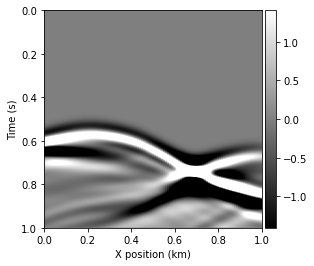

In [171]:
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, 0, T)

In [172]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure()
im = plt.imshow(np.transpose(u.data[0,40:-40,40:-40]),
                cmap="Greys", animated=True, vmin=-1e0, vmax=1e0, aspect=1,
                extent=[model.origin[0], model.origin[0] + 1e-3 * model.shape[0] * model.spacing[0],
                        model.origin[1] + 1e-3*model.shape[1] * model.spacing[1], model.origin[1]])
plt.xlabel('X position (km)',  fontsize=20)
plt.ylabel('Depth (km)',  fontsize=20)
plt.tick_params(labelsize=20)
im2 = plt.imshow(np.transpose(v), vmin=0, vmax=0, cmap=cm.GnBu, aspect=1,
                 extent=[model.origin[0], model.origin[0] + 1e-3 * model.shape[0] * model.spacing[0],
                         model.origin[1] + 1e-3*model.shape[1] * model.spacing[1], model.origin[1]], alpha=.4)
def updatefig(i):
    im.set_array(np.transpose(u.data[i*5,40:-40,40:-40]))
    return im, im2

ani = animation.FuncAnimation(fig, updatefig, frames=np.linspace(0, nt/5-1, nt//5, dtype=np.int64), blit=True, interval=50)
plt.close(ani._fig)
HTML(ani.to_html5_video())